In [203]:
#pip install xgboost
!brew install libomp

Updating Homebrew...
==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).
==> New Formulae
arturo              gitlint             libslirp            pdm
bit-git             googletest          ncspot              pickle
blaze               gost                nicotine-plus       rain
device-mapper       isort               node@14             taskwarrior-tui
fnm                 libdrm              openjdk@8           vint
gcalcli             libfuse             or-tools
==> Updated Formulae
Updated 785 formulae.
==> Deleted Formulae
boost@1.55                 meson-internal             woboq_codebrowser
boost@1.59                 mysql-connector-c++@1.1
llvm@6                     scw@1

==> Downloading https://homebrew.bintray.com/bottles/libomp-11.0.0.mojave.bottle
==> Downloading from https://d29vzk4ow07wi7.cloudfront.net/0716db5d51938b2fae8ab
######################################################################## 100.0%#                  78.7%
==> Pouring libomp-11.0.0.mojav

In [3]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb
#from surprise import Reader, Dataset
#from surprise import BaselineOnly
#from surprise import KNNBaseline
#from surprise import SVD
#from surprise import SVDpp
#from surprise.model_selection import GridSearchCV

In [4]:
news_csv = pd.read_csv("news_corpus_processed.csv")
news_csv
rating_csv = pd.read_csv("user_profile.csv")
rating_csv

,session_id,user_id,item_id,read_time,rating
0,1420507,16,1630,2,4
1,1421031,1,685,4,5
2,1421267,39,1908,1,2
3,1421586,42,242,1,3
4,1421620,50,3975,1,3
...,...,...,...,...,...
9995,1429814,19,1299,1,3
9996,1430005,15,4255,1,2
9997,1430246,40,946,4,4
9998,1430267,41,1726,7,5


In [5]:
split_value = int(len(rating_csv) * 0.80)
train_data = rating_csv[:split_value]
test_data = rating_csv[split_value:]

In [6]:
len(train_data)

8000

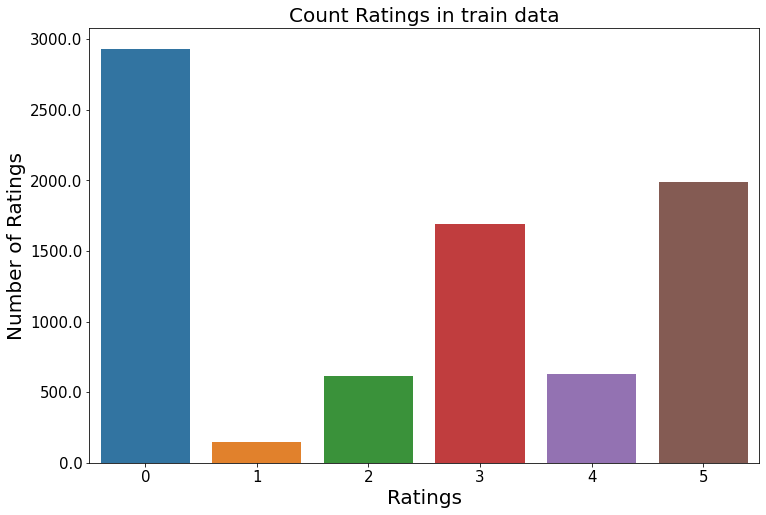

In [7]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=train_data)

ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [8]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.rating, (df.user_id, df.item_id)))
    return sparse_data

In [9]:
train_sparse_data = get_user_item_sparse_matrix(train_data)
train_sparse_data

<51x4655 sparse matrix of type '<class 'numpy.int64'>'
	with 8000 stored elements in Compressed Sparse Row format>

In [10]:
test_sparse_data = get_user_item_sparse_matrix(test_data)
test_sparse_data

<51x4654 sparse matrix of type '<class 'numpy.int64'>'
	with 2000 stored elements in Compressed Sparse Row format>

In [11]:
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print("Global Average Rating: {}".format(global_average_rating))

Global Average Rating: 3.730465666929755


In [12]:
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1  
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1 
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings

In [13]:
average_rating_user = get_average_rating(train_sparse_data, True)
average_rating_user

{1: 3.956140350877193,
 2: 3.6923076923076925,
 3: 3.8796296296296298,
 4: 3.7358490566037736,
 5: 3.9611650485436893,
 6: 3.607594936708861,
 7: 3.564814814814815,
 8: 3.8210526315789473,
 9: 3.5739130434782607,
 10: 3.865979381443299,
 11: 3.7009345794392523,
 12: 3.657142857142857,
 13: 3.888888888888889,
 14: 3.6930693069306932,
 15: 3.712962962962963,
 16: 3.8842105263157896,
 17: 3.6530612244897958,
 18: 3.696629213483146,
 19: 3.925233644859813,
 20: 3.7362637362637363,
 21: 3.7155963302752295,
 22: 3.701923076923077,
 23: 3.865546218487395,
 24: 3.706422018348624,
 25: 3.7448979591836733,
 26: 3.8376068376068377,
 27: 3.594059405940594,
 28: 3.68,
 29: 3.7663551401869158,
 30: 3.5638297872340425,
 31: 3.734042553191489,
 32: 3.6666666666666665,
 33: 3.89010989010989,
 34: 3.6818181818181817,
 35: 3.6557377049180326,
 36: 3.7045454545454546,
 37: 3.5625,
 38: 3.68,
 39: 3.814432989690722,
 40: 3.776595744680851,
 41: 3.616822429906542,
 42: 3.945945945945946,
 43: 3.857142857142

In [14]:
avg_rating_news = get_average_rating(train_sparse_data, False)
len(avg_rating_news)

3026

In [15]:
avg_rating_news

{3: 4.0,
 4: 3.75,
 5: 3.0,
 6: 5.0,
 7: 4.0,
 8: 5.0,
 13: 3.0,
 15: 5.0,
 16: 5.0,
 17: 5.0,
 18: 4.0,
 22: 4.333333333333333,
 23: 4.0,
 25: 5.0,
 27: 3.0,
 34: 3.0,
 35: 5.0,
 38: 4.0,
 39: 5.0,
 41: 3.0,
 42: 3.0,
 43: 3.0,
 45: 5.0,
 47: 5.0,
 48: 3.0,
 52: 3.0,
 53: 3.0,
 54: 5.0,
 58: 3.0,
 60: 3.0,
 61: 5.0,
 62: 5.0,
 64: 5.0,
 69: 3.0,
 70: 5.0,
 72: 5.0,
 76: 5.0,
 78: 5.0,
 79: 5.0,
 80: 3.6666666666666665,
 81: 5.0,
 82: 5.0,
 84: 5.0,
 85: 4.0,
 86: 4.333333333333333,
 89: 5.0,
 90: 3.0,
 95: 3.0,
 96: 5.0,
 99: 5.0,
 104: 5.0,
 106: 4.0,
 107: 3.0,
 111: 5.0,
 112: 5.0,
 113: 5.0,
 114: 3.0,
 116: 5.0,
 117: 5.0,
 119: 3.0,
 120: 5.0,
 121: 3.0,
 126: 3.0,
 127: 5.0,
 130: 3.0,
 131: 3.0,
 133: 5.0,
 136: 2.0,
 137: 5.0,
 138: 5.0,
 139: 3.6666666666666665,
 140: 3.0,
 141: 4.0,
 142: 3.6666666666666665,
 143: 5.0,
 144: 3.6666666666666665,
 146: 3.0,
 147: 4.0,
 148: 4.5,
 149: 3.0,
 151: 5.0,
 152: 5.0,
 153: 5.0,
 156: 4.333333333333333,
 157: 3.0,
 158: 5.0,
 159: 5

In [16]:
total_users = len(np.unique(rating_csv["user_id"]))
train_users = len(average_rating_user)
uncommonUsers = total_users - train_users
                  
print("Total no. of Users = {}".format(total_users))
print("No. of Users in train data= {}".format(train_users))
print("No. of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. of Users = 50
No. of Users in train data= 50
No. of Users not present in train data = 0(0.0%)


In [17]:
total_news = len(np.unique(rating_csv["item_id"]))
train_news = len(avg_rating_news)
uncommonNews = total_news - train_news
                  
print("Total no. of News Articles = {}".format(total_news))
print("No. of News Articles in train data= {}".format(train_news))
print("No. of News Articles not present in train data = {}({}%)".format(uncommonNews, np.round((uncommonNews/total_news)*100), 2))

Total no. of News Articles = 4150
No. of News Articles in train data= 3026
No. of News Articles not present in train data = 1124(27.0%)


In [18]:
def compute_user_similarity(sparse_matrix, limit=51):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(31467).reshape(617,51)
    
    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar
    
    return similar_arr

In [19]:
similar_user_matrix = compute_user_similarity(train_sparse_data, 51)

In [20]:
len(similar_user_matrix)

617

In [21]:
similar_user_matrix[6]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00279746, 0.00304328, 0.00403435, 0.00431029, 0.00448574,
       0.00451217, 0.00699957, 0.00892239, 0.01202309, 0.01267643,
       0.01298375, 0.01308065, 0.01317251, 0.01520157, 0.0175108 ,
       0.0181843 , 0.01855857, 0.01864224, 0.01869664, 0.01920204,
       0.01933806, 0.02013281, 0.02558575, 0.02591977, 0.02614693,
       0.0297001 , 0.03020033, 0.03098341, 0.03134144, 0.03437583,
       0.03621163, 0.03782558, 0.04051531, 0.04391623, 0.06331701,
       1.        ])

In [22]:
train_sparse_data.shape[1]

4655

In [23]:
len(train_data)

8000

In [24]:
news_heading = news_csv[["Article_id","Synopsis", "Date"]]
news_heading.head()

,Article_id,Synopsis,Date
0,1,uri box offic collect action star vicki kausha...,2019-02-08
1,2,dosti ke side effect box offic collect day sap...,2019-02-09
2,3,late ranveer singh struck gold box offic look ...,2019-02-14
3,4,gulli boy box offic predict accord girish joha...,2019-02-14
4,5,gulli boy box offic collect day loos inspir li...,2019-02-15


In [25]:
def compute_news_similarity_count(sparse_matrix, news_heading, article_id):
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)
    no_of_similar_articles = news_heading.loc[article_id][1], similarity[article_id].count_nonzero()
    return no_of_similar_articles

In [28]:
similar_articles = compute_news_similarity_count(train_sparse_data, news_heading, 3)
print("Similar News Articles = {}".format(similar_articles))

Similar News Articles = ('gulli boy box offic predict accord girish johar gulli boy loos base life mumbai street rapper naezi divin set cash regist ring first day', 201)


In [29]:
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_news):
    users, news_articles, ratings = sparse.find(sparse_matrix)
    print( news_articles.shape)
    uniq_users = np.unique(users)
    print(uniq_users.shape)
    uniq_news = np.unique(news_articles)
    print(uniq_news.shape)
    np.random.seed(15) 
    user = np.random.choice(uniq_users, no_of_users, replace = False)
    print(len(users))
    news = np.random.choice(uniq_news, no_of_news, replace = True)
    print("USERS",users)
    mask = np.logical_and(np.isin(users, user), np.isin(news_articles, news))
    sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], news_articles[mask])), 
                                                     shape = (max(user)+1, max(news)+1))
    return sparse_matrix

In [30]:
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data, 50, 40)

(5068,)
(50,)
(3026,)
5068
USERS [ 7 10  5 ... 36 31 48]


In [31]:
print(train_sample_sparse_matrix)
train_sample_sparse_matrix.shape

  (1, 1062)	3
  (4, 1486)	5
  (5, 3652)	5
  (5, 3947)	3
  (5, 4282)	3
  (6, 1486)	5
  (7, 2015)	4
  (8, 621)	3
  (8, 738)	1
  (8, 2431)	3
  (8, 3996)	3
  (9, 3836)	2
  (10, 464)	5
  (10, 2437)	5
  (11, 3836)	5
  (11, 4093)	5
  (12, 3884)	3
  (14, 1482)	3
  (15, 2624)	3
  (15, 4582)	2
  (16, 1348)	5
  (16, 1630)	4
  (16, 3996)	5
  (17, 397)	3
  (17, 3996)	5
  :	:
  (29, 1482)	3
  (30, 152)	5
  (30, 1715)	3
  (31, 621)	5
  (31, 3506)	5
  (32, 2104)	3
  (33, 1348)	5
  (33, 3652)	5
  (36, 3996)	3
  (40, 2323)	5
  (40, 2624)	3
  (40, 3947)	3
  (41, 2890)	5
  (42, 1715)	5
  (42, 3675)	4
  (44, 2015)	5
  (44, 3675)	4
  (45, 397)	3
  (45, 2766)	5
  (47, 634)	5
  (48, 2766)	4
  (49, 4368)	3
  (50, 1943)	5
  (50, 2741)	3
  (50, 2766)	2


(51, 4583)

In [32]:
test_sparse_matrix_matrix = get_sample_sparse_matrix(test_sparse_data, 50, 20)

(1299,)
(50,)
(1127,)
1299
USERS [28 34 47 ... 39  5 40]


In [33]:
print(test_sparse_matrix_matrix )

  (4, 1397)	5
  (7, 1561)	5
  (7, 2990)	3
  (11, 393)	5
  (12, 4586)	1
  (13, 1211)	2
  (15, 442)	5
  (15, 1051)	2
  (20, 2436)	2
  (20, 4444)	3
  (22, 1344)	4
  (22, 2129)	5
  (22, 4342)	3
  (25, 1586)	3
  (27, 2043)	3
  (33, 442)	2
  (33, 1033)	5
  (33, 1881)	5
  (36, 2667)	5
  (38, 442)	5
  (39, 3929)	5
  (46, 1912)	3
  (50, 1912)	3


In [34]:
def create_new_similar_features(sample_sparse_matrix):
    global_avg_rating = get_average_rating(sample_sparse_matrix, False)
    global_avg_users = get_average_rating(sample_sparse_matrix, True)
    global_avg_news = get_average_rating(sample_sparse_matrix, False)
    sample_train_users, sample_train_news, sample_train_ratings = sparse.find(sample_sparse_matrix)
    new_features_csv_file = open("new_features.csv", mode = "w")
    
    for user, news, rating in zip(sample_train_users, sample_train_news, sample_train_ratings):
        similar_arr = list()
        similar_arr.append(user)
        similar_arr.append(news)
        similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero())
        
        similar_users = cosine_similarity(sample_sparse_matrix[user], sample_sparse_matrix).ravel()
        indices = np.argsort(-similar_users)[1:]
        ratings = sample_sparse_matrix[indices, news].toarray().ravel()
        #print(ratings)
        top_similar_user_ratings = list(ratings[ratings != 0][:1])
       # print(top_similar_user_ratings)
        top_similar_user_ratings.extend([global_avg_rating[news]] * (1 - len(ratings)))
        similar_arr.extend(top_similar_user_ratings)
        
        similar_news = cosine_similarity(sample_sparse_matrix[:,news].T, sample_sparse_matrix.T).ravel()
        similar_news_indices = np.argsort(-similar_news)[1:]
        similar_news_ratings = sample_sparse_matrix[user, similar_news_indices].toarray().ravel()
        top_similar_news_ratings = list(similar_news_ratings[similar_news_ratings != 0][:1])
        #print("yugh",top_similar_news_ratings)
        top_similar_news_ratings.extend([global_avg_users[user]] * (1-len(top_similar_news_ratings)))
        similar_arr.extend(top_similar_news_ratings)
        
        similar_arr.append(global_avg_users[user])
        similar_arr.append(global_avg_news[news])
        similar_arr.append(rating)
       # print(rating)
        new_features_csv_file.write(",".join(map(str, similar_arr)))
        new_features_csv_file.write("\n")
        
    new_features_csv_file.close()
    new_features_df = pd.read_csv('new_features.csv', names = ["user_id", "article_id", "gloabl_average", "similar_user_rating1",
                                                                "similar_news_rating", "user_average","news_average" ,"rating"])
    return new_features_df

In [35]:
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix)

In [36]:
print(train_new_similar_features)

    user_id  article_id  gloabl_average  similar_user_rating1  \
0        30         152        3.846154                   3.0   
1        17         397        3.846154                   3.0   
2        45         397        3.846154                   3.0   
3        10         464        3.846154                   5.0   
4        22         533        3.846154                   3.0   
..      ...         ...             ...                   ...   
60       11        4093        3.846154                   5.0   
61        5        4282        3.846154                   3.0   
62       49        4368        3.846154                   3.0   
63       15        4582        3.846154                   4.0   
64       24        4582        3.846154                   2.0   

    similar_news_rating  user_average  news_average  rating  
0              4.000000           5.0           5.0     NaN  
1              5.000000           4.0           3.0     3.0  
2              5.000000          

In [37]:
test_new_similar_features = create_new_similar_features(test_sparse_matrix_matrix)

In [38]:
test_new_similar_features = test_new_similar_features.fillna(0)
test_new_similar_features.head()

,user_id,article_id,gloabl_average,similar_user_rating1,similar_news_rating,user_average,news_average,rating
0,11,393,3.652174,5.0,5.0,5.0,5.0,0.0
1,15,442,3.652174,5.0,2.0,3.5,4.0,5.0
2,33,442,3.652174,5.0,5.0,4.0,4.0,2.0
3,38,442,3.652174,5.0,5.0,5.0,4.0,5.0
4,33,1033,3.652174,5.0,4.0,5.0,5.0,0.0


In [39]:
x_train = train_new_similar_features.drop(["user_id", "article_id","rating"], axis = 1)

x_test = test_new_similar_features.drop(["user_id", "article_id", "rating"], axis = 1)

y_train = train_new_similar_features["rating"]

y_test = test_new_similar_features["rating"]

In [40]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [41]:
clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
clf.fit(x_train, y_train)

[12:36:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=10, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=False,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [42]:
y_pred_test = clf.predict(x_test)

In [43]:
rmse_test = error_metrics(y_test, y_pred_test)
print("RMSE = {}".format(rmse_test))

RMSE = 1.611777306874781
